In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

import optuna
from optuna.samplers import TPESampler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from pathlib import Path
from flask import Flask, request, jsonify, render_template
import joblib
from datetime import datetime
import os

In [2]:
# Load data
iris = load_iris()
x = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

In [3]:
# Train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=42)

In [4]:
def objective(trial):
    # Suggest which model to use
    model_type = trial.suggest_categorical('model_type', ['svc', 'random_forest'])
    
    if model_type == 'svc':
        params = {
            'svc_model__C': trial.suggest_float('svc_C', 1e-3, 1e3, log=True),
            'svc_model__kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf']),
            'svc_model__gamma': trial.suggest_float('svc_gamma', 1e-3, 1e1, log=True)
        }
        model = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('svc_model', SVC(probability=True))
        ]).set_params(**params)
    else :
        params = {
            'forest_model__n_estimators': trial.suggest_int('rf_n_estimators', 50, 300),
            'forest_model__max_depth': trial.suggest_int('rf_max_depth', 3, 20),
            'forest_model__min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
            'forest_model__max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
        }
        model = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('forest_model', RandomForestClassifier(random_state=42))
        ]).set_params(**params)
    
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    return score.mean()


In [5]:
# Create Optuna study
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

[I 2025-05-20 23:26:42,423] A new study created in memory with name: no-name-c9283d41-6b71-4c72-8385-96b9cb8a8b7f


In [6]:
# Optimize with silent mode to reduce output
study.optimize(objective, n_trials=50, show_progress_bar=False)

[I 2025-05-20 23:26:43,192] Trial 0 finished with value: 0.95 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 233, 'rf_max_depth': 13, 'rf_min_samples_split': 3, 'rf_max_features': 'sqrt'}. Best is trial 0 with value: 0.95.
[I 2025-05-20 23:26:43,215] Trial 1 finished with value: 0.5583333333333333 and parameters: {'model_type': 'svc', 'svc_C': 17.71884735480682, 'svc_kernel': 'poly', 'svc_gamma': 0.0070689749506246055}. Best is trial 0 with value: 0.95.
[I 2025-05-20 23:26:43,632] Trial 2 finished with value: 0.95 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 126, 'rf_max_depth': 12, 'rf_min_samples_split': 5, 'rf_max_features': 'log2'}. Best is trial 0 with value: 0.95.
[I 2025-05-20 23:26:44,094] Trial 3 finished with value: 0.9583333333333334 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 141, 'rf_max_depth': 11, 'rf_min_samples_split': 9, 'rf_max_features': 'log2'}. Best is trial 3 with value: 0.9583333333333334.
[I 2025-

In [7]:
# Best parameters
print(f"\nBest trial:")
trial = study.best_trial
print(f"  Value (accuracy): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Value (accuracy): 0.9750
  Params: 
    model_type: svc
    svc_C: 825.8687310240758
    svc_kernel: rbf
    svc_gamma: 0.0010324741282667113


In [8]:
# Train final model with best parameters
if trial.params['model_type'] == 'svc':
    best_model = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('svc_model', SVC(probability=True))
    ]).set_params(**{f'svc_model__{k.split("_")[-1]}': v 
                    for k,v in trial.params.items() if k.startswith('svc_')})
else:
    best_model = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('forest_model', RandomForestClassifier(random_state=42))
    ]).set_params(**{f'forest_model__{k.split("_")[-1]}': v 
                   for k,v in trial.params.items() if k.startswith('rf_')})

best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)

In [9]:
# Evaluation metrics
final_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'Precision': precision_score(y_test, y_pred, average='weighted')
}

print("\nFinal Model Performance:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Model Performance:
Accuracy: 0.9667
F1 Score: 0.9666
Precision: 0.9697


In [10]:
# 1. Save the best model

model_dir = Path("saved_models")
model_dir.mkdir(exist_ok=True)
model_path = model_dir / "best_iris_model.joblib"
joblib.dump(best_model, model_path)
print(f"\nSaved best model to: {model_path}")


Saved best model to: saved_models\best_iris_model.joblib


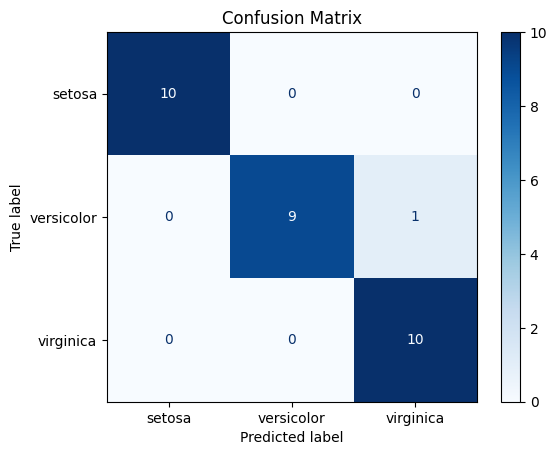

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Feature Importance (if Random Forest)
if trial.params['model_type'] == 'random_forest':
    importances = best_model.named_steps['forest_model'].feature_importances_
    plt.figure(figsize=(10, 5))
    plt.barh(iris.feature_names, importances)
    plt.title('Feature Importance')
    plt.show()

In [13]:

# =============================================
# Model Deployment with Flask
# =============================================

# Save the trained model
def save_model(model, metrics, feature_names, target_names):
    model_info = {
        'model': model,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'metrics': metrics,
        'features': list(feature_names),  # Convert to list if not already
        'classes': list(target_names)     # Convert to list if not already
    }
    os.makedirs('model', exist_ok=True)
    model_path = os.path.join('model', 'iris_model.joblib')
    joblib.dump(model_info, model_path)
    return model_path

# Call it like this:
model_path = save_model(best_model, final_metrics, iris.feature_names, iris.target_names)

# Create Flask app
app = Flask(__name__)

# Load model function
def load_model():
    return joblib.load(model_path)

# API endpoint for predictions
@app.route('/predict', methods=['POST'])
def predict_api():
    try:
        model_info = load_model()
        model = model_info['model']
        
        # Get data from JSON request
        data = request.get_json()
        features = [float(data[feature]) for feature in model_info['features']]
        input_data = pd.DataFrame([features], columns=model_info['features'])
        
        # Make prediction
        prediction = model.predict(input_data)[0]
        probabilities = model.predict_proba(input_data)[0]
        
        return jsonify({
            'prediction': model_info['classes'][prediction],
            'confidence': float(probabilities[prediction]),
            'probabilities': {
                cls: float(prob) 
                for cls, prob in zip(model_info['classes'], probabilities)
            }
        })
    except Exception as e:
        return jsonify({'error': str(e)}), 400

# Web interface
@app.route('/')
def home():
    model_info = load_model()
    return render_template('index.html', 
                         features=model_info['features'],
                         classes=model_info['classes'],
                         metrics=model_info['metrics'])

# Create HTML template directory and file
os.makedirs('templates', exist_ok=True)
with open('templates/index.html', 'w') as f:
    f.write('''<!DOCTYPE html>
<html>
<head>
    <title>Iris Classifier</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        .form-group { margin-bottom: 1rem; }
        .result { margin-top: 2rem; padding: 1rem; background: #f8f9fa; }
    </style>
</head>
<body>
    <div class="container mt-5">
        <h1 class="mb-4">Iris Flower Classifier</h1>
        
        <div class="row">
            <div class="col-md-6">
                <form id="predictionForm">
                    {% for feature in features %}
                    <div class="form-group">
                        <label for="{{ feature }}">{{ feature }}</label>
                        <input type="number" step="0.1" class="form-control" id="{{ feature }}" 
                               name="{{ feature }}" required>
                    </div>
                    {% endfor %}
                    <button type="submit" class="btn btn-primary">Predict</button>
                </form>
                
                <div id="result" class="result" style="display: none;">
                    <h4>Prediction Result</h4>
                    <p><strong>Class:</strong> <span id="prediction"></span></p>
                    <p><strong>Confidence:</strong> <span id="confidence"></span></p>
                    <div id="probabilities"></div>
                </div>
            </div>
            
            <div class="col-md-6">
                <h4>Model Metrics</h4>
                <ul>
                    {% for metric, value in metrics.items() %}
                    <li>{{ metric }}: {{ "%.2f"|format(value) }}</li>
                    {% endfor %}
                </ul>
                
                <h4 class="mt-4">Class Labels</h4>
                <ol>
                    {% for class in classes %}
                    <li>{{ class }}</li>
                    {% endfor %}
                </ol>
            </div>
        </div>
    </div>

    <script>
        document.getElementById('predictionForm').addEventListener('submit', async (e) => {
            e.preventDefault();
            
            const formData = new FormData(e.target);
            const data = {};
            formData.forEach((value, key) => data[key] = parseFloat(value));
            
            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify(data)
                });
                
                const result = await response.json();
                
                if (response.ok) {
                    document.getElementById('prediction').textContent = result.prediction;
                    document.getElementById('confidence').textContent = 
                        (result.confidence * 100).toFixed(2) + '%';
                    
                    let probsHtml = '<p><strong>Probabilities:</strong></p><ul>';
                    for (const [cls, prob] of Object.entries(result.probabilities)) {
                        probsHtml += `<li>${cls}: ${(prob * 100).toFixed(2)}%</li>`;
                    }
                    probsHtml += '</ul>';
                    document.getElementById('probabilities').innerHTML = probsHtml;
                    
                    document.getElementById('result').style.display = 'block';
                } else {
                    alert(`Error: ${result.error}`);
                }
            } catch (error) {
                alert(`Error: ${error.message}`);
            }
        });
    </script>
</body>
</html>''')

if __name__ == '__main__':
    try:
        # Try default port first
        print("\nAttempting to start server on port 5000...")
        app.run(host='127.0.0.1', port=5000, debug=False)
    except OSError as e:
        if "Address already in use" in str(e):
            print("Port 5000 in use, trying port 8080...")
            try:
                app.run(host='127.0.0.1', port=8080, debug=False)
            except Exception as e:
                print(f"Failed to start server: {e}")
        else:
            print(f"Unexpected error: {e}")
    except Exception as e:
        print(f"Server failed to start: {e}")


Attempting to start server on port 5000...
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [20/May/2025 23:29:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2025 23:29:30] "POST /predict HTTP/1.1" 200 -
